# San Francisco Crime
## Considerations

### Imports

In [3]:
#Feature Engineering + Plotting
import pandas as pd
import matplotlib
import seaborn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math

#Machine Learning
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb


#Options
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
seaborn.set()

### Map
Before we dive into the data, we look at the map of San Francisco. The map data is from OpenStreetMap.

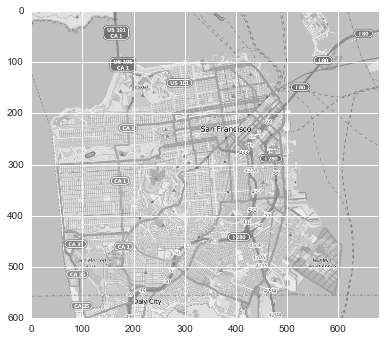

In [6]:
mapdata = np.loadtxt("../data/sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))

## Data
### Import Data

In [4]:
data_train = pd.read_csv('../data/train.csv', sep = ',')

### Rough Data Analysis
We see that there are 878049 observations and no missing values. For the numeric features we see that the Y (Latitude) feature has a min of 37.7 and 50% quantile of 37.77, but a max of 90. So it seems there are some outliers.

In [41]:
data_train.describe(percentiles=[]).transpose()

count        mean       std         min         50%    max
X  878049.0 -122.422616  0.030354 -122.513642 -122.416420 -120.5
Y  878049.0   37.771020  0.456893   37.707879   37.775421   90.0

The most important information from the following table for the categorical features is that there are 10 PdDistrists and 39 categories.

In [42]:
data_train.describe(percentiles=[], include=['O']).transpose()

count  unique                           top    freq
Dates       878049  389257           2011-01-01 00:01:00     185
Category    878049      39                 LARCENY/THEFT  174900
Descript    878049     879  GRAND THEFT FROM LOCKED AUTO   60022
DayOfWeek   878049       7                        Friday  133734
PdDistrict  878049      10                      SOUTHERN  157182
Resolution  878049      17                          NONE  526790
Address     878049   23228        800 Block of BRYANT ST   26533

### Target Variable
We need to predict in which category a crime falls using the other features. Therefore we use classification and not regression.

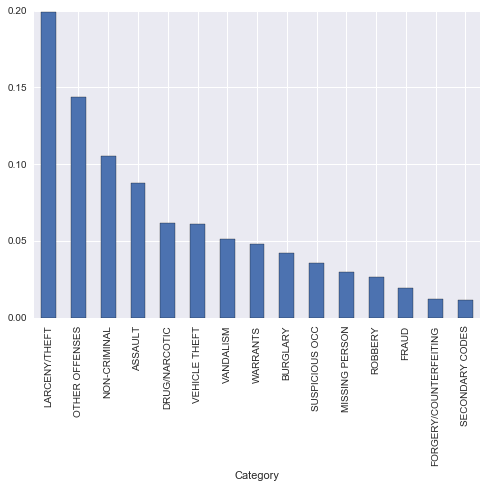

In [43]:
d = data_train.groupby('Category').size().sort_values(ascending=False)
dPercent = d / d.sum()
dPercent[:15].plot(kind='bar')

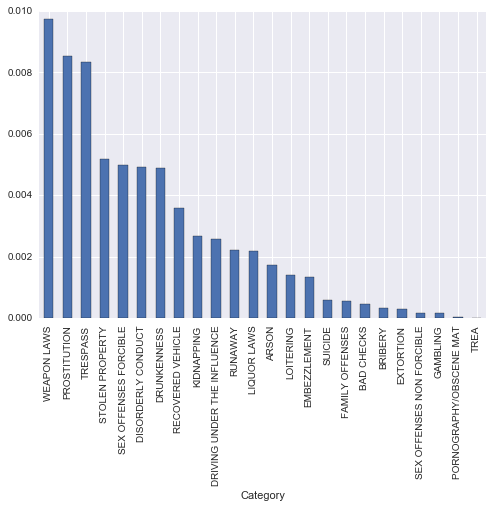

In [44]:
dPercent[15:].plot(kind="bar")

We see that the top 15 crimes (from 39) contain 93,33% of all crimes.

In [45]:
dPercent[:15].sum()

0.9331871000365582

In the following plot we see that different crimes happening at the same time and location is not rare and because of that we have to account for that while predicting

1     550477
2      97879
3      34002
4       4358
5       1392
6        467
7        165
8         80
9         39
10        18
11        11
12         6
13         5
16         1
14         1
dtype: int64

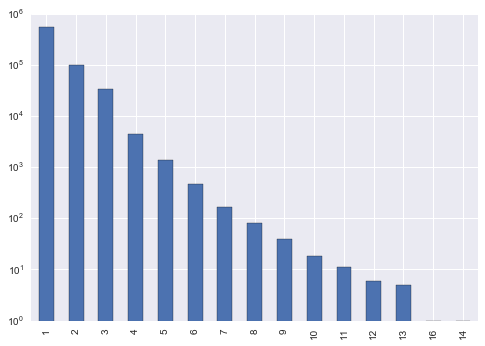

In [5]:
counts = data_train.groupby(['Dates', 'X', 'Y']).size()

counts.value_counts().plot('bar', logy=True)
counts.value_counts()

### Test Data
The training data and test data rotate every week. Besides the target variable "Category" also "Descript" and "Resolution" are missing from the the test set.

In [46]:
data_test = pd.read_csv('../data/test.csv', sep = ',')

We can only check if there are other PdDistrics in the test data, as locations will be different as this is real data. Also "Descript" and "Resolution" are not available in the test set.

In [47]:
len(np.setdiff1d(data_test['PdDistrict'].unique(), data_train['PdDistrict'].unique()))

0

### Data Anomalies
#### LongLat
First convert all X/Y Values to numeric to be able to compare them.

In [48]:
d_train_x = pd.to_numeric(data_train['X'])
d_train_y = pd.to_numeric(data_train['Y'])
d_test_x = pd.to_numeric(data_test['X'])
d_test_y = pd.to_numeric(data_test['Y'])

The values for the bounding box of the map are based on the agreed upon bounding box in the kaggle forums.

In [49]:
data_train["X"][(d_train_x < -122.52469) | (d_train_x > -122.33663)].unique()

array([-120.5])

In [50]:
data_train["Y"][(d_train_y < 37.69862) | (d_train_y > 37.82986)].unique()

array([ 90.])

In [51]:
data_test["X"][(d_test_x < -122.52469) | (d_test_x > -122.33663)].unique()

array([-120.5])

In [52]:
data_test["Y"][(d_test_y < 37.69862) | (d_test_y > 37.82986)].unique()

array([ 90.])

Outliers all (test and train data) have a Longtitude of -120.5 and a Latitude of 90. To get rid of these we preprocess the data.

### Data Preprocessing

In [53]:
def preprocess_coordinates(data):
    data = data[data['X'] != -120.5]
    data = data[data['Y'] != 90]
    return data

## Features

### Standard Features
As the target variable has 39 features, we didn't find any good visualisations whether the features correlate or not. Therefore we depend more upon the later feature importance

#### Dates
Using this feature, we derive all time based features. Also we could use this feature to derive DayOfWeek.

In [23]:
def feature_dates(data):
    data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d %H:%M:%S')
    return np.asarray(data['Dates']), ['Dates']

#### DayOfWeek
The Day of the week the crime was commited (From 'Monday' to 'Sunday')

In [24]:
def feature_day_of_week(data):
    return pd.get_dummies(data['DayOfWeek']), data['DayOfWeek'].unique().tolist()

#### PdDistrict
The name of the police department district

In [25]:
def feature_pd_district(data):
    return pd.get_dummies(data['PdDistrict']), data_train['PdDistrict'].unique().tolist()

#### Address
Approximate street address of the crime incident

In [26]:
def feature_address(data):
    return np.asarray(data['Address'])

#### X (Longitude) + Y (Latitude)
The commited crime is highly dependent on the location specified by Longtitude and Latitude

In [27]:
def feature_longitude(data):
    return (data.X - data.X.mean()) / data.X.std(), ['Longitude(X)']

In [28]:
def feature_latitude(data):
    return (data.Y - data.Y.mean()) / data.Y.std(), ['Latitude(Y)']

### Derived Features
#### Time-based
We use dummies for each of the datetime features (from year to minute).

In [7]:
def feature_year(data):
    df = data
    df['year'] = pd.to_datetime(data['Dates']).dt.year
    years = np.asarray(df['year'])
    return years, ['year']

In [8]:
def feature_month(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    months = np.asarray(df['month'])
    return months, ['month']

In [9]:
def feature_week(data):
    df = data
    df['week'] = pd.to_datetime(data['Dates']).dt.week
    weeks = np.asarray(df['week'])
    return weeks, ['week']

In [10]:
def feature_day(data):
    df = data
    df['day'] = pd.to_datetime(data['Dates']).dt.day
    days = np.asarray(df['day'])
    return days, ['day']

In [11]:
def feature_hour(data):
    df = data
    df['hour'] = pd.to_datetime(data['Dates']).dt.hour
    hour = np.asarray(df['hour'])
    return hour, ['hour']

In [12]:
def feature_minute(data):
    df = data
    df['minute'] = pd.to_datetime(data['Dates']).dt.minute
    minute = np.asarray(df['minute'])
    return minute, ['Minute']

Even though we have the hour feature, we try to abstract from it using day times

In [13]:
def feature_daytime(data):
    df = data
    df['hour'] = pd.to_datetime(data['Dates']).dt.hour
    daytimes = ['night', 'morning', 'noon', 'afternoon', 'evening']
    res = pd.cut(df['hour'], [-1,6,11,15,18,22,25], labels=['night', 'morning', 'noon', 'afternoon', 'evening', 'night2']).copy()
    res[res == 'night2'] = 'night'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), daytimes

We think that some crimes happen more often than other depending on the season

In [14]:
def feature_seasons(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    seasons = ['winter', 'spring', 'summer', 'fall']
    res = pd.cut(df['month'], [0,2,3,8,11,12], labels=['winter', 'spring', 'summer', 'fall', 'winter2'])
    res[res == 'winter2'] = 'winter'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), seasons

We would like to know if some crimes can be predicted using a holiday feature. Luckily this time we know which holiday calendar to use (in contrast to DMC)

In [15]:
def feature_holiday(data):
    data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d')
    cal = calendar()
    date_range = pd.date_range(start='1/1/2003 ', end='5/13/2015') #known from description
    holidays = cal.holidays(start=date_range.min(), end=date_range.max())
    data['isHoliday'] = data['Dates'].dt.date.astype('datetime64').isin(holidays)
    return np.asarray(data['isHoliday']), ['isHoliday']

#There are 25653 holidays in the training set

The suicide rate on christmas is higher than on other times in the year

In [16]:
def feature_xmas(data):
    data['Dates'] = pd.to_datetime(data['Dates'])
    d = np.asarray(data['Dates'].dt.week > 48)
    return d, ['xmas']

#### Address-based
The crime happened on a street corner iff there are 2 addresses separated with an '/'

In [17]:
def feature_street_corner(data):
    d = np.asarray(data['Address'].apply(lambda x: 1 if '/' in x else 0))  
    return d, ['Street Corner']

In [18]:
def feature_add_ending(data):
    add_ending = ['ST', 'AV', 'WY', 'BL', 'DR', 'CT', 'TR', 'HY', 'RD', 'PZ', 'PL',
       'LN', 'AY', 'AL', 'CR', 'MS', 'ER', 'EX',
       'AR']    
    add = data['Address'].str[-2:]
    
    for i, ending in enumerate(add_ending):
        add[-add.isin(add_ending)] = 'NON'

    df = pd.get_dummies(add)
    
    return np.asarray(df), np.asarray(df.columns).tolist()

#ValueError: all the input array dimensions except for the concatenation axis must match exactly

#### Location-based

Like others we tried to use a grid but without success.

Also we calculate which crime is most propable per region for the training and the test set

In [19]:
def feature_crimeProbPerReg_train(data):
    return feature_crimeProbPerReg(data)

def feature_crimeProbPerReg_test(data):
    return feature_crimeProbPerReg(data, test=True)

def feature_crimeProbPerReg(data, test=False):
    df = data
    bin_num = 10
    bin_labels = [i+1 for i in range(bin_num)]
    
    if not test:
        df['binX'], binsX = pd.cut(df.X, bin_num, labels=bin_labels, retbins=True)
        df['binY'], binsY = pd.qcut(df.Y, bin_num, labels=bin_labels, retbins=True)
        
        crimeProReg = df.groupby(['binX', 'binY', 'Category']).size().unstack('binX').unstack('binY')
        crimeProReg = crimeProReg/crimeProReg.sum()
        crimeProReg = crimeProReg.fillna(0)
        crimeProReg = crimeProReg.transpose()
        crimeProReg = crimeProReg.reset_index(['binX', 'binY'])

        pickle.dump(binsX, open("binsX.p", "wb"))
        pickle.dump(binsY, open("binsY.p", "wb"))
        pickle.dump(crimeProReg, open("crimeProbPerReg.p", "wb" ))  #save table with crime rates pro crime and region
    else:        
        binsX = pickle.load(open("binsX.p", "rb"))
        binsY = pickle.load(open("binsY.p", "rb"))
        df['binX'] = pd.cut(df.X, binsX, labels=bin_labels)
        df['binY'] = pd.cut(df.Y, binsY, labels=bin_labels)
        
        crimeProReg = pickle.load(open("crimeProbPerReg.p", "rb"))
    
#    print(df)
    mergedR = df.merge(crimeProReg, on=['binX', 'binY'])#.fillna(0)
#    print(mergedR)
    res = mergedR.iloc[:, len(df.columns):len(mergedR.columns)]
    res = (res-res.mean())/res.std()
    return np.asanyarray(res), res.columns.tolist()

#### Coordinate based distance feat
The following one is a distance based feature for the 15 most popular crime categories. First of all for every district the mean X and Y coordinates of the most popular crimes will calculated. After that distance of every crime to the mean coordinates will calculated as feature.

In [20]:
def feature_CrimeDistance(data, featureData):

    dataM = featureData.as_matrix()
    district = data['PdDistrict']
    districtU = district.unique()
    category = data['Category']
    popCategory = category.value_counts(normalize=False, sort=True, ascending=False, bins=None,)[:15]
    policeDepartment = featureData['PdDistrict'].as_matrix()

    # mean  x,y coordinates grouped by district and category
    x_mean = data['X'].groupby([data['PdDistrict'],data['Category']]).mean()
    y_mean = data['Y'].groupby([data['PdDistrict'],data['Category']]).mean()

    # x,y coordinates for the generation of the features
    x = pd.to_numeric(featureData['X'].as_matrix())
    y = pd.to_numeric(featureData['Y'].as_matrix())

    # the matrizes are to store the mean coordinates
    X_meanTable = np.zeros((districtU.shape[0], (popCategory.shape[0])))
    Y_meanTable = np.zeros((districtU.shape[0], (popCategory.shape[0])))

    # the mean coordinates are stored within the following for loop
    for i in range(0, districtU.shape[0]):

        for j in range(0, popCategory.shape[0]):

            X_meanTable[i][j] = x_mean[districtU[i]][popCategory.index[j]]
            Y_meanTable[i][j] = y_mean[districtU[i]][popCategory.index[j]]


    # declaration of the empty dataframe for storing the new features
    df = np.zeros((dataM.shape[0],popCategory.size))
    names = []

    # the first loop iterates through the popular categories
    for t in range(0, popCategory.size):

        names.append('distance_' + str(popCategory.index[t]))

        # the second loop iterates through the input dataframe which is for generation
        for i in range(0, dataM.shape[0]):

            # the last loop is to check which district is to use
            for j in range(0, districtU.size):

                if (policeDepartment[i] == districtU[j]):
                    
                    # calculation of the inverse of the euclidian distance
                    df[i][t] = 1/(math.sqrt((x[i] - X_meanTable[j][t])**2 + (y[i] - Y_meanTable[j][t])**2))

    # normalization 
    dFrame = pd.DataFrame(np.asarray(df))
    dFrame = (dFrame - dFrame.mean())/dFrame.std()

    return np.asarray(dFrame), names

### Left out Features
The following features were left out early on.

#### Descript
This feature is not available in the test set and is only a description of the crime.

#### Resolution
This one is also not available in the test set. The only thing we could imagine to use the percentage of crimes solved of a all crime categories as we think that crimes that get resolved more often don't get commited as often.

### Generate Feature Set

In [33]:
def getY(data):
    numCat = len(data['Category'].unique()) 
    d = data['Category']
    d = d.astype('category')
    d = d.cat.rename_categories(np.arange(numCat))
    return np.asarray(d)

def getX(data, test_set=False):    
    feature_methodes = [  feature_pd_district, feature_daytime,\
                          feature_day_of_week, feature_seasons, feature_street_corner,\
                          feature_year, feature_latitude, feature_longitude,
                          feature_month, feature_week, feature_hour, feature_minute,
                          feature_holiday, feature_xmas]

    if(test_set == False):
        feature_methodes += [feature_crimeProbPerReg_train]
    else:
        feature_methodes += [feature_crimeProbPerReg_test]
    
    feats = []
    names = []

    for func in feature_methodes:
        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        print(f.shape)    
        feats.append(f)
        names.extend(n)
    
    #CrimeDistance needs two parameter as we had no time to use pickle (like in crimeProbPerReg)
    #f, n = feature_CrimeDistance(data_train, data)
    #print(f.shape)
    #feats.append(f)
    #names.extend(n)
    
    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names

In [34]:
print("get train and test features")

train_data, test_data = train_test_split(data_train, test_size=0.3)

train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)
test_y = getY(test_data)

get train and test features
<function feature_pd_district at 0x7f8ced53e6a8>
(614634, 10)
<function feature_daytime at 0x7f8cecfea598>
(614634, 5)
<function feature_day_of_week at 0x7f8cecfc9510>
(614634, 7)
<function feature_seasons at 0x7f8cecfc9378>
(614634, 4)
<function feature_street_corner at 0x7f8ceca80730>
(614634, 1)
<function feature_year at 0x7f8ceca801e0>
(614634, 1)
<function feature_latitude at 0x7f8ced549730>
(614634, 1)
<function feature_longitude at 0x7f8cecfbd158>
(614634, 1)
<function feature_month at 0x7f8cecfc9ea0>
(614634, 1)
<function feature_week at 0x7f8cecfc9950>
(614634, 1)
<function feature_hour at 0x7f8cecfc90d0>
(614634, 1)
<function feature_minute at 0x7f8cecfc9598>
(614634, 1)
<function feature_holiday at 0x7f8cecfc9ae8>
(614634, 1)
<function feature_xmas at 0x7f8cecfc98c8>
(614634, 1)
<function feature_crimeProbPerReg_train at 0x7f8cecfbdd08>
(614634, 39)
<function feature_pd_district at 0x7f8ced53e6a8>
(263415, 10)
<function feature_daytime at 0x7f8cec

### Feature Selection

#### PCA

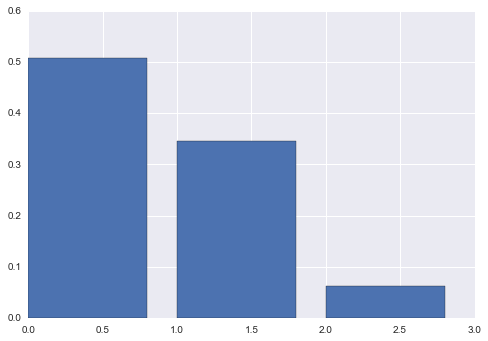

[ 345.94841644  235.47376656   43.03004234]


In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(train_x)
pc = pca.explained_variance_

plt.bar(np.arange(pc.shape[0]), pca.explained_variance_ratio_)
plt.show()
print(pc)

#### Random Forest
Random Forests can be used to get the feature importance

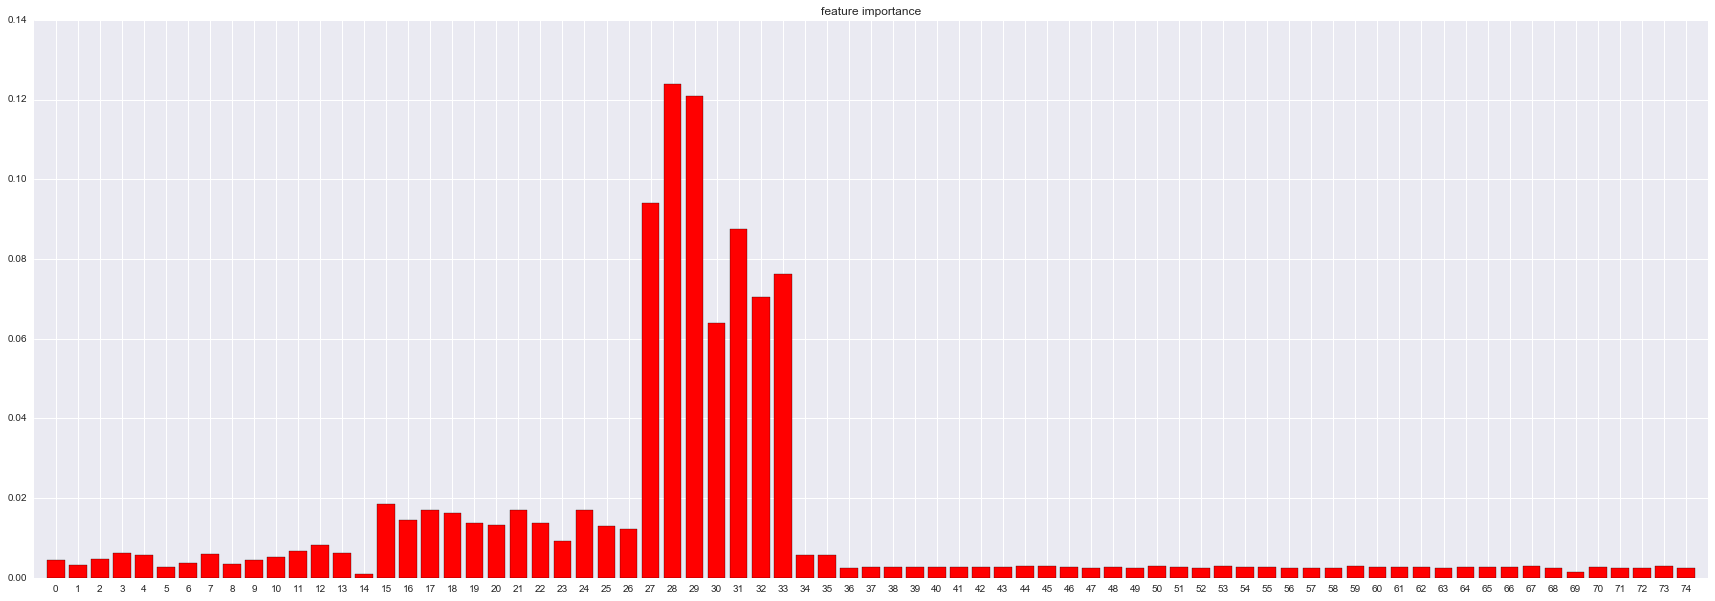

0 NORTHERN 0.00440757776498
1 PARK 0.00315839274277
2 INGLESIDE 0.00460461097425
3 BAYVIEW 0.00622144659531
4 RICHMOND 0.00571280530474
5 CENTRAL 0.00274343327996
6 TARAVAL 0.00376534530365
7 TENDERLOIN 0.00608496844044
8 MISSION 0.00356036468147
9 SOUTHERN 0.00453354395724
10 night 0.00509486971634
11 morning 0.00666523899779
12 noon 0.00834576792624
13 afternoon 0.00627293430931
14 evening 0.000844690424802
15 Wednesday 0.0184087105326
16 Friday 0.0144382911594
17 Tuesday 0.0170211267768
18 Sunday 0.0163363343297
19 Thursday 0.0137271105075
20 Monday 0.0132144044285
21 Saturday 0.0169931268121
22 winter 0.0138596514039
23 spring 0.00923089846989
24 summer 0.0169203307009
25 fall 0.0130946823318
26 Street Corner 0.0122542025304
27 year 0.093952249169
28 Latitude(Y) 0.123920096953
29 Longitude(X) 0.120979466975
30 month 0.0638602301381
31 week 0.0873942514885
32 hour 0.0704519087556
33 Minute 0.07626581894
34 isHoliday 0.00573764485742
35 xmas 0.0057164411018
36 ARSON 0.00254404052915


In [36]:
model =RandomForestClassifier(n_estimators=1)

train = model.fit(train_x, train_y)
pred = model.predict(test_x)

# feature importance
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

#bar chart plot for feature importance
#because of the huge number of the features, legend of the bars are shown in the terminal
plt.figure(figsize=(30, 10))
plt.title("feature importance")
plt.bar(range(importance.shape[0]), importance, color="r", align="center")
plt.xlim([-1, importance.shape[0]])
plt.xticks(range(importance.shape[0]))
plt.show()

counter = 0
for i in range(indices.shape[0]):
        print(str(i) + " " + str(names[i]) + " " + str(importance[i]))

## Get finish Feature Sets

We selected the best combination of features:

In [313]:
def getY(data):
    numCat = len(data['Category'].unique()) 
    d = data['Category']
    d = d.astype('category')
    d = d.cat.rename_categories(np.arange(numCat))
    return np.asarray(d)

def getX(data, test_set=False):
    
    feature_methodes = [  feature_pd_district, feature_daytime,\
                          feature_day_of_week, feature_seasons, feature_street_corner,\
                          feature_year, feature_latitude, feature_longitude]

#    if(test_set == False):
#        feature_methodes += [feature_crimeProbPerReg_train]
#    else:
#        feature_methodes += [feature_crimeProbPerReg_test]
    
    feats = []
    names = []

    for func in feature_methodes:
#        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
#        print(f.shape)    
        feats.append(f)
        names.extend(n)

    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names #sum(names,[]) ???

In [322]:
train_data, test_data = train_test_split(data_train, test_size=0.3)

#crimes = train_data.groupby('Category').size()
#crimes = crimes.sort_values(ascending=False)
#topCat = crimes[:10].index
#mask = train_data.Category.isin(topCat)
#train_data_filtered = train_data[mask].copy()

In [81]:
train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)
test_y = getY(test_data)

<function feature_pd_district at 0x7f6fff609e18>
(614634, 10)
<function feature_daytime at 0x7f6fedc11158>
(614634, 5)
<function feature_day_of_week at 0x7f6fff6027b8>
(614634, 7)
<function feature_seasons at 0x7f6fedc110d0>
(614634, 4)
<function feature_street_corner at 0x7f6fed656a60>
(614634, 1)
<function feature_year at 0x7f6fff6141e0>
(614634, 13)
<function feature_latitude at 0x7f6ff405a2f0>
(614634, 1)
<function feature_longitude at 0x7f6fff610b70>
(614634, 1)
<function feature_month at 0x7f6fedc112f0>
(614634, 12)
<function feature_week at 0x7f6fff4e2b70>
(614634, 26)
<function feature_hour at 0x7f6fff610268>
(614634, 24)
<function feature_minute at 0x7f6fed4a3c80>
(614634, 60)
<function feature_holiday at 0x7f6fff43da60>
(614634, 1)
<function feature_xmas at 0x7f6fed4118c8>
(614634, 1)
<function feature_crimeProbPerReg_train at 0x7f6fff47d1e0>
(614634, 39)
(614634, 15)
<function feature_pd_district at 0x7f6fff609e18>
(263415, 10)
<function feature_daytime at 0x7f6fedc11158>
(2

## Classification
For each tried Classifier we output the accuracy and the logloss. After that we select the one which has the best score (lower is better).

### Logistic Regression
The logistic regression is a statistical approach to predict the class labels. It needs some assumptions like binomial distribution for the response variable. The Classificator trains for every label an separate regression model. The model with the highest likelihood gets the classification. This model provides a good result in our case.

In [ ]:
model = LogisticRegression()

print("Train logReg")
train = model.fit(train_x, train_y)

print("Test logReg")
pred = model.predict(test_x)

print("Evaluate logReg")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))
print("Logloss")
print(log_loss(test_y, pred))

Train logReg


### Naive Bayes
This model is also a statistical approach. It trains a Naive bayes network and classifies the data with the aposteriori likelihood. Its a very fast benchmark classificator which provides in this case the poorest results

In [ ]:
model = NaiveBayes()

print("Train NB")
train = model.fit(train_x, train_y)

print("Test NB")
pred = model.predict(test_x)

print("Evaluate NB")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))
print("Logloss")
print(log_loss(test_y, pred))

### Random Forest
Random Forest is classificator which generates many decision trees with random samples. For every tree it try to maximize the information gain. It classifies according to a majority decision

In [301]:
model = RandomForest()

print("Train RF")
train = model.fit(train_x, train_y)

print("Test RF")
pred = model.predict(test_x)

print("Evaluate RF")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))
print("Logloss")
print(log_loss(test_y, pred))

ImportError: No module named 'Classifiers'

### Stochastic Gradient Descent with SVM
This Classifier trains for every level of the Output a separate svm (one against all) with the learning methods stochastic gradient descent. This learning methods updating the weight vector in direction with the steepest error reduction.

In [87]:
model = SGDClassifier()

print("Train SVM")
train = model.fit(train_x, train_y)

print("Test SVM")
pred = model.predict(test_x)

print("Evaluate SVM")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))
print("Logloss")
print(log_loss(test_y, pred))

Train SVM
Test SVM
Evaluate SVM
Confusion Matrix
[[   0   30    0 ...,   20   38    0]
 [   0  975    0 ..., 1227 2026    6]
 [   0    4    0 ...,   12    1    0]
 ..., 
 [   0  285    0 ..., 2654  400    6]
 [   0  373    0 ...,  265 1820    4]
 [   0  110    0 ...,  110  286    2]]
Accuracy
0.195900005694
Logloss


ValueError: y_true and y_pred have different number of classes 39, 2

### AdaBoost Classifier

This is a meta-estimator that first fits the original dataset and then fits additional copies of the classifier on the same dataset. To do this but weights of misclassified instances are adjusted so it focuses more on edge cases

In [82]:
model = AdaBoostClassifier(n_estimators = 50)
%time model.fit(train_x, train_y)
pred = model.predict_proba(test_x)
print("LogLoss")
print(log_loss(test_y, pred))

CPU times: user 7min 36s, sys: 14.7 s, total: 7min 51s
Wall time: 7min 53s
LogLoss
3.578336656


### XGBoost
TODO

In [77]:
xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x, label=test_y)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 39
param['eval_metric'] = 'mlogloss'
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 10

In [31]:
bst = xgb.train(param, xg_train, num_round, watchlist );

[0]	train-mlogloss:3.396497	test-mlogloss:3.435181
[1]	train-mlogloss:3.238897	test-mlogloss:3.301652
[2]	train-mlogloss:3.118476	test-mlogloss:3.201402
[3]	train-mlogloss:3.021560	test-mlogloss:3.121741
[4]	train-mlogloss:2.939604	test-mlogloss:3.055494
[5]	train-mlogloss:2.869724	test-mlogloss:2.999454
[6]	train-mlogloss:2.807736	test-mlogloss:2.950952
[7]	train-mlogloss:2.753364	test-mlogloss:2.908893
[8]	train-mlogloss:2.705014	test-mlogloss:2.871919
[9]	train-mlogloss:2.661760	test-mlogloss:2.839303
[10]	train-mlogloss:2.622261	test-mlogloss:2.810223
[11]	train-mlogloss:2.586442	test-mlogloss:2.784218
[12]	train-mlogloss:2.553958	test-mlogloss:2.761132
[13]	train-mlogloss:2.523926	test-mlogloss:2.740186
[14]	train-mlogloss:2.496538	test-mlogloss:2.721264
[15]	train-mlogloss:2.471320	test-mlogloss:2.704391
[16]	train-mlogloss:2.447962	test-mlogloss:2.688911
[17]	train-mlogloss:2.426084	test-mlogloss:2.674850
[18]	train-mlogloss:2.405878	test-mlogloss:2.662155
[19]	train-mlogloss:2.

In [32]:
pred = bst.predict( xg_test );

In [33]:
testd_y = pd.get_dummies(data_test['Category'])
log_loss(testd_y, pred)

KeyError: 'Category'

## Result

For our submission we use the best configuration based on the evaluation:

In [78]:
data_train = pd.read_csv('../data/train.csv', sep = ',')
data_test = pd.read_csv('../data/test.csv', sep = ',')

data_train = preprocess_coordinates(data_train)


train_x, names = getX(data_train)
train_y = getY(data_train)
test_x, names = getX(data_test, test_set=True)

xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x)

bst = xgb.train(param, xg_train, num_round, watchlist )
pred = bst.predict( xg_test )

<function feature_pd_district at 0x7f0cf025e268>
(877982, 10)
<function feature_daytime at 0x7f0cf0256620>
(877982, 5)
<function feature_day_of_week at 0x7f0cf024b488>
(877982, 7)
<function feature_seasons at 0x7f0d2dd9e400>
(877982, 4)
<function feature_street_corner at 0x7f0cf01e5e18>
(877982, 1)
<function feature_year at 0x7f0cf024b048>
(877982, 13)
<function feature_latitude at 0x7f0cf02416a8>
(877982, 1)
<function feature_longitude at 0x7f0cf02e8400>
(877982, 1)
<function feature_month at 0x7f0cf02560d0>
(877982, 12)
<function feature_week at 0x7f0cf01e5ae8>
(877982, 26)
<function feature_hour at 0x7f0cf024bd08>
(877982, 24)
<function feature_minute at 0x7f0cf0241510>
(877982, 60)
<function feature_holiday at 0x7f0cf02ff598>
(877982, 1)
<function feature_xmas at 0x7f0cf01e5158>
(877982, 1)
<function feature_pd_district at 0x7f0cf025e268>
(884262, 10)
<function feature_daytime at 0x7f0cf0256620>
(884262, 5)
<function feature_day_of_week at 0x7f0cf024b488>
(884262, 7)
<function feat

[0]	train-mlogloss:3.450076	test-mlogloss:3.449862
[1]	train-mlogloss:3.319534	test-mlogloss:3.319139


KeyboardInterrupt: 

In [122]:
output = pd.DataFrame(pred, index=data_test.index, columns=data_train['Category'].unique())
output.to_csv("results.csv", index_label="Id")